In [1]:
import pretty_midi
import IPython
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from DataAPI import MIDI_Dataset, DataAPI, piano_roll_to_pretty_midi
from MidiAPI import MidiAPI
from NetworkAPI import NetworkAPI

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Co trzeba zrobić:
- Miary podobieństwa między utworami (przynajmniej 2-3)
- Przetestowanie różnych architektur sieci i ich ewaluacja
- Dodać do instrumentów perkusje w fajny sposób (edycja pliku MidiAPI.py - trochę juz zacząłem)
- Przetesotować, różne długości sekwencji i fps

## Wczytanie datasetu i wybranie wszystkich podstawowych parametrów
- seq_len - długość sekwencji na jakich będzie uczyć się sieć
- fps - ilość dzwięków na sekunde (dokładność konwersji pliku dzwiękowego)
- songs_in_batch - ile utworów wchodzi do jednego losowania batcha
- batch_size - ile sekwencji wchodzi na raz do sieci
- embedding_dim - rozmiar embeddingu w sieci
- hidden_dim - rozmiar warstwy LSTM
- lead - główny instrument generowanego utworu
- path - ścieżka do pliku z plikami .mid i .midi

### Ciekawe leady to:
- Acoustic Bass
- Celesta
- Choir Aahs
- Church Organ
- Drawbar Organ
- FX 1 (rain)
- FX 2 (soundtrack)
- Marimba
- Pad 1 (new age)
- Synth Choir
- Synth Strings 1
- Synth Strings 2
- Taiko Drum
- Vibraphone

In [3]:
seq_len = 20
fps = 5
songs_in_batch = 8
batch_size = 128
embedding_dim = 64
hidden_dim = 32
lead = pretty_midi.instrument_name_to_program('Pad 3 (polysynth)')
path = './sample_data/'

midi_dataset = MIDI_Dataset(path, fps=fps)
data_api = DataAPI(midi_dataset, songs_in_batch=songs_in_batch, batch_size=batch_size, sequence_length=seq_len)

## Zdefiniowanie architektury sieci

In [4]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, unique_notes, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(unique_notes, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, dropout=0.2)
        self.linear = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * seq_len, 512),
            nn.Linear(512, unique_notes))

    def forward(self, x):
        batch_size, _ = x.shape
        embeds = self.embeddings(x)
        lstm_out, _ = self.lstm(embeds.view(self.seq_len, batch_size, -1))
        outputs = self.linear(lstm_out.view(batch_size, -1))
        return outputs

In [12]:
model = LSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim, unique_notes=data_api.unique_notes_len, seq_len=seq_len)
network_api = NetworkAPI(model, data_api, 'first_working_network', optim.SGD(model.parameters(), lr=0.05))
# network_api.load_checkpoint()

## Trenowanie sieci
- iterations - ilość przetworzonych batchy
- verbose_every_iteration - co ile iteracji ma lecieć print

In [6]:
network_api.train_loop(iterations=1000, verbose_every_iteration=200)

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 1000
Learning rate= 0.05
------------------------------------------------
| Iteration:   1 | Time:   0.36s | Loss:  7.33 |
------------------------------------------------
| Iteration: 201 | Time:   5.28s | Loss:  5.33 |
------------------------------------------------
| Iteration: 401 | Time:   5.54s | Loss:  5.49 |
------------------------------------------------
| Iteration: 601 | Time:   6.29s | Loss:  6.37 |
------------------------------------------------
| Iteration: 801 | Time:   7.60s | Loss:  4.81 |
| Total time elapsed: 30 seconds 520 miliseconds 


## Wykres loss rate
- Jeżeli jest więcej niż 10 000 iteracji, wykres jest uśredniony co 1000 iterację
- Jeżeli jest mniej niż 10 000 iteracji loss jest wyplotowany bezpośrednio

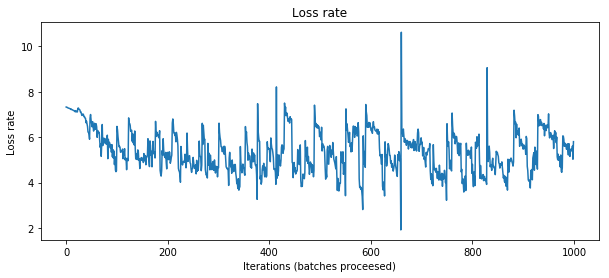

In [7]:
network_api.plot_errors()

## Wygenerowanie sampla z naszej sieci 
- song_len - długość wygenerowanego utworu (w sekundach)
- temperature - coś z paczki pretty midi
- program - rodzaj instrumentu

In [8]:
sample_midi = network_api.generate_sample_midi(song_len = 10, temperature = 1.0, program = lead)
sample_midi.write('./first_sample.mid')

## Testowy odsłuch utworu
- na bardzo brzydkim instrumencie - lepiej odpalić plik .midi w Windows Media Player, albo dowolnym innym odtwarzaczu, który obsługuje ten format

In [9]:
IPython.display.Audio(sample_midi.synthesize(fs=8000), rate=8000)

## Wykres Piano Roll wygenerowanego utworu

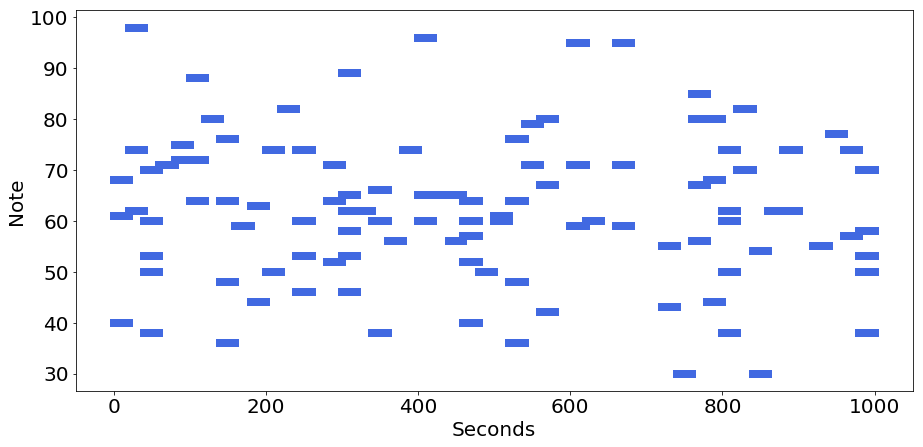

In [10]:
midi_api = MidiAPI(midi = sample_midi)
midi_api.plot_piano_roll()

## Porównanie Piano Rolla wygenerowanego utworu z przykłądowym z training setu
- jeszcze nie działa tak jak trzeba

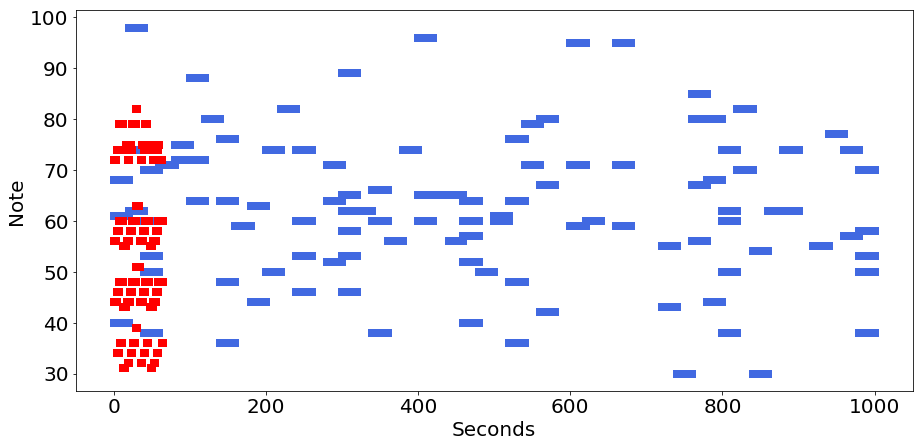

In [11]:
training_midi = pretty_midi.PrettyMIDI('./sample_data/4_clubbers__secrets.mid')
midi_api.compare_piano_rolls(training_midi, fps)